In [57]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [58]:
import os
import glob

In [59]:
os.listdir('cifar/hbnode')

['HBNODE_1e3.txt',
 'HBNODE_1e1.txt',
 'HBNODE_1e5.txt',
 'HBNODE_1e2.txt',
 'HBNODE_1e0.txt',
 'HBNODE_1e4.txt']

In [60]:
class Output_Parser:
    def __init__(self, filename):
        self.size = 0
        # train
        self.train_iter = []
        self.train_loss = []
        self.train_nfe = []
        self.train_fnfe = []
        self.train_time_iter = []
        self.train_time = []
        # test
        self.test_iter = []
        self.test_loss = []
        self.test_acc = []
        self.test_nfe = []
        
        readfile = open(filename, 'r')
        readlines = readfile.readlines()
        for i, line in enumerate(readlines):
            # first 4 lines are misc output
            if i < 4:
                continue
            parsed_output = self.parseline(line)
            self.size +=1
            
            if parsed_output is not None:
                self.train_iter.append(parsed_output[0])
                self.train_loss.append(parsed_output[1])
                self.train_nfe.append(parsed_output[2])
                self.train_fnfe.append(parsed_output[3])
                self.train_time_iter.append(parsed_output[4])
                self.train_time.append(parsed_output[5])
#             elif len(parsed_output) == 4:
#                 self.test_iter.append(parsed_output[0])
#                 self.test_loss.append(parsed_output[1])
#                 self.test_acc.append(parsed_output[2])
#                 self.test_nfe.append(parsed_output[3])
        
    def parseline(self, row):
        row = row.split(" ")
        if row[0] == "Train||":
            train_iter = int(row[2])
            train_loss = float(row[5])
            train_nfe = float(row[8])
            train_fnfe = float(row[11])
            train_time_iter = float(row[14])
            train_time = float(row[17])
            return train_iter, train_loss, train_nfe, train_fnfe, train_time_iter, train_time
        else:
            return None
            
#         if row[0] == "Test":
#             test_iter = int(row[3])
#             test_loss = float(row[6])
#             test_acc = float(row[9])
#             test_nfe = float(row[12])
#             return test_iter, test_loss, test_acc, test_nfe

    def get(self):
        return {
            "train_iter": self.train_iter,
            "train_loss": self.train_loss,
            "train_nfe": self.train_nfe,
            "train_fnfe": self.train_fnfe,
            "train_bnfe": [self.train_nfe[i] - self.train_fnfe[i] for i in range(len(self.train_nfe))],
            "train_time_iter": self.train_time_iter,
            "train_time": self.train_time,
#             "test_iter": self.test_iter,
#             "test_loss": self.test_loss,
#             "test_acc": self.test_acc,
#             "test_nfe": self.test_nfe
        }
    def get_df(self):
        return pd.DataFrame(self.get())

In [61]:
hb1e3 = Output_Parser('cifar/hbnode/HBNODE_1e3.txt').get_df()

In [62]:
hb1e3.head()

,train_iter,train_loss,train_nfe,train_fnfe,train_bnfe,train_time_iter,train_time
0,1,1.8006,41.193,20.0,21.193,148.54,2.4757
1,2,1.5611,40.489,20.0,20.489,144.84,4.8898
2,3,1.4229,40.061,20.0,20.061,142.84,7.4010
3,4,1.2786,40.091,20.0,20.091,143.10,9.7860
4,5,1.1806,40.214,20.0,20.214,143.03,12.2980


In [63]:
def calc_means(file_list, colName):
    data_list = [Output_Parser(file).get_df()[colName] for file in file_list]
    data_list = np.array(data_list)
    return data_list.mean(axis=0)

In [144]:
def plot_forwardnfe_epoch(y, x, ax=plt):
    XLAB_SIZE = 15
    YLAB_SIZE = 15
    ax.plot(y, x)
    ax.xlabel("Epoch", fontsize=XLAB_SIZE)
    ax.ylabel("NFE Forward", fontsize=YLAB_SIZE)
    ax.show()
    
def x_y_z(model):
    df = pd.DataFrame(make_stacks(glob.glob(f'cifar/{model}/*.txt'), "train_fnfe", "train_bnfe"))
    df = df.sort_values(by='tol')
    df.head()

    x = df.train_fnfe
    y = df.train_bnfe
    z = df.tol
    return x, y, z

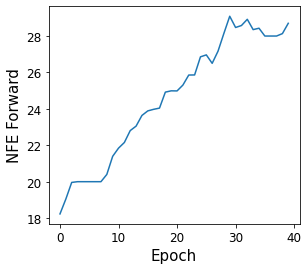

In [65]:
nfe_forward = calc_means(glob.glob('cifar/hbnode/*.txt'), 'train_fnfe')
plot_forwardnfe_epoch(np.arange(40), nfe_forward)

In [66]:
def n2f(name):
    if name[-7:] == '1e0.txt':
        return [1e-0] * 40
    if name[-7:] == '1e1.txt':
        return [1e-1] * 40
    if name[-7:] == '1e2.txt':
        return [1e-2] * 40
    if name[-7:] == '1e3.txt':
        return [1e-3] * 40
    if name[-7:] == '1e4.txt':
        return [1e-4] * 40
    if name[-7:] == '1e5.txt':
        return [1e-5] * 40
    
def make_stacks(file_list, colName1, colName2):
    col1_stack = np.hstack([Output_Parser(file).get_df()[colName1] for file in file_list])
    col2_stack = np.hstack([Output_Parser(file).get_df()[colName2] for file in file_list])
    tol_name_stack = np.hstack([n2f(file) for file in file_list])
    return {colName1:col1_stack, colName2:col2_stack, 'tol':tol_name_stack}

In [67]:
df = pd.DataFrame(make_stacks(glob.glob('cifar/hbnode/*.txt'), "train_fnfe", "train_bnfe"))
df = df.sort_values(by='tol')
df.head()

,train_fnfe,train_bnfe,tol
119,50.673,80.457,0.00001
102,49.785,83.085,0.00001
103,49.632,85.078,0.00001
104,49.295,85.235,0.00001
105,48.806,86.114,0.00001


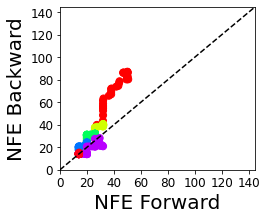

In [69]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
BIGGEST_SIZE = 30
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

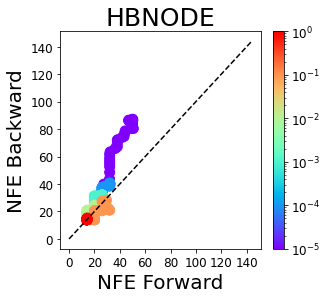

In [74]:
df = pd.DataFrame(make_stacks(glob.glob('cifar/hbnode/*.txt'), "train_fnfe", "train_bnfe"))
df = df.sort_values(by='tol')
df.head()

x = df.train_fnfe
y = df.train_bnfe
z = df.tol

lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
plt.scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140])
plt.yticks([0, 20, 40, 60, 80, 100, 120, 140])
cbar = plt.colorbar(spacing='proportional')
# cbar.mappable.set_clim(1e-0, 1e-5)
# cbar.set_ticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.xlabel("NFE Forward")
plt.ylabel("NFE Backward")
plt.title("HBNODE", fontsize=BIGGER_SIZE)
plt.plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
plt.show()

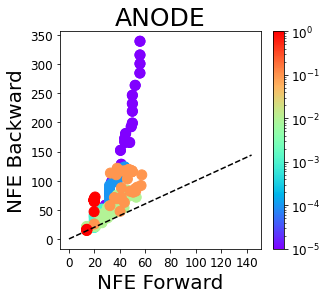

In [75]:
df = pd.DataFrame(make_stacks(glob.glob('cifar/anode/*.txt'), "train_fnfe", "train_bnfe"))
df = df.sort_values(by='tol')
df.head()

x = df.train_fnfe
y = df.train_bnfe
z = df.tol

lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
plt.scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140])
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
cbar = plt.colorbar(spacing='proportional')
# cbar.mappable.set_clim(1e-0, 1e-5)
# cbar.set_ticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.xlabel("NFE Forward")
plt.ylabel("NFE Backward")
plt.title("ANODE", fontsize=BIGGER_SIZE)
plt.plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
plt.show()

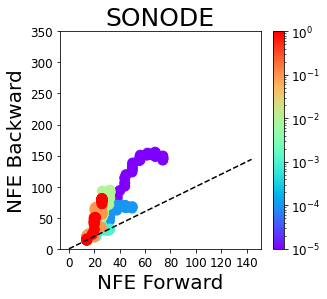

In [143]:
df = pd.DataFrame(make_stacks(glob.glob('cifar/sonode/*.txt'), "train_fnfe", "train_bnfe"))
df = df.sort_values(by='tol')
df.head()

x = df.train_fnfe
y = df.train_bnfe
z = df.tol

lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
plt.scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140])
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
plt.ylim([0, 350])
cbar = plt.colorbar(spacing='proportional')
# cbar.mappable.set_clim(1e-0, 1e-5)
# cbar.set_ticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.xlabel("NFE Forward")
plt.ylabel("NFE Backward")
plt.title("SONODE", fontsize=BIGGER_SIZE)
plt.plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
plt.show()

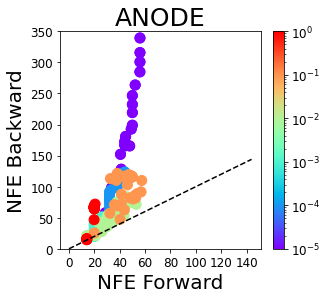

In [141]:
df = pd.DataFrame(make_stacks(glob.glob('cifar/anode/*.txt'), "train_fnfe", "train_bnfe"))
df = df.sort_values(by='tol')
df.head()

x = df.train_fnfe
y = df.train_bnfe
z = df.tol

lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
plt.scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140])
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
plt.ylim([0, 350])
cbar = plt.colorbar(spacing='proportional')
plt.xlabel("NFE Forward")
plt.ylabel("NFE Backward")
plt.title("ANODE", fontsize=BIGGER_SIZE)
plt.plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
plt.show()

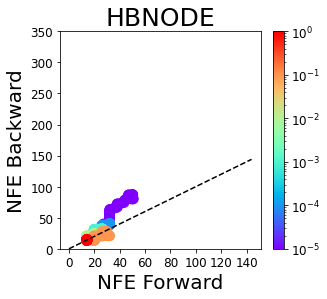

In [146]:
x, y, z = x_y_z('hbnode')

lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
plt.scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.xticks([0, 20, 40, 60, 80, 100, 120, 140])
plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
plt.ylim([0, 350])
cbar = plt.colorbar(spacing='proportional')
# cbar.mappable.set_clim(1e-0, 1e-5)
# cbar.set_ticks([1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
plt.xlabel("NFE Forward")
plt.ylabel("NFE Backward")
plt.title("HBNODE", fontsize=BIGGER_SIZE)
plt.plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
plt.show()

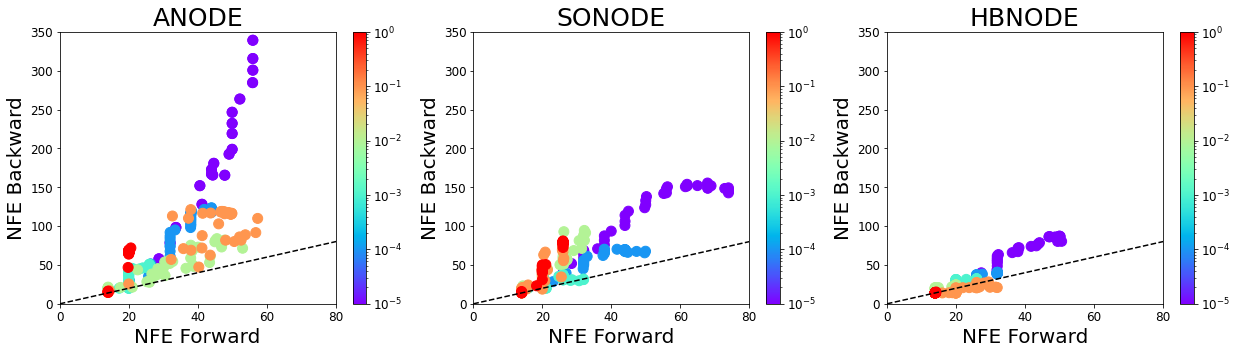

In [166]:
fig, axes = plt.subplots(1, 3, figsize=(21, 5))
lim = 145
g=4
plt.rcParams['figure.figsize']=(g+.5,g)
norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True)


x,y,z = x_y_z('anode')
axes[0].scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='rainbow'), ax=axes[0])
axes[0].set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
axes[0].set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
axes[0].set_ylim([0, 350])
axes[0].set_xlim([0, 80])
axes[0].plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
axes[0].set_xlabel("NFE Forward")
axes[0].set_ylabel("NFE Backward")
axes[0].set_title("ANODE", fontsize=BIGGER_SIZE)


x,y,z = x_y_z('sonode')
axes[1].scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='rainbow'), ax=axes[1])
axes[1].set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
axes[1].set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
axes[1].set_ylim([0, 350])
axes[1].set_xlim([0, 80])
axes[1].plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
axes[1].set_xlabel("NFE Forward")
axes[1].set_ylabel("NFE Backward")
axes[1].set_title("SONODE", fontsize=BIGGER_SIZE)

x,y,z = x_y_z('hbnode')
axes[2].scatter(x, y, c=z, cmap='rainbow', s=100, norm=mpl.colors.LogNorm(vmin=1e-5, vmax=1e-0, clip=True))
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='rainbow'), ax=axes[2])
axes[2].set_yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
axes[2].set_xticks([0, 20, 40, 60, 80, 100, 120, 140])
axes[2].set_ylim([0, 350])
axes[2].set_xlim([0, 80])
axes[2].plot(np.arange(lim), np.arange(lim), c='k', linestyle='--')
axes[2].set_xlabel("NFE Forward")
axes[2].set_ylabel("NFE Backward")
axes[2].set_title("HBNODE", fontsize=BIGGER_SIZE)

plt.show()

In [167]:
print(4)

4
